In [149]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [150]:
def pam_gray(b):
    if len(b)>1:
        return (1-2*b[0])*(2**len(b[1:]) - pam_gray(b[1:]))
    return 1-2*b[0]

def qam(num_bits_per_symbol, normalize=True):
    try:
        assert num_bits_per_symbol % 2 == 0 # is even
        assert num_bits_per_symbol >0 # is larger than zero
    except AssertionError as error:
        raise ValueError("num_bits_per_symbol must be a multiple of 2") \
        from error
    assert isinstance(normalize, bool), "normalize must be boolean"

    # Build constellation by iterating through all points
    c = np.zeros([2**num_bits_per_symbol], dtype=np.complex64)
    for i in range(0, 2**num_bits_per_symbol):
        b = np.array(list(np.binary_repr(i,num_bits_per_symbol)),
                     dtype=np.int16)
        c[i] = pam_gray(b[0::2]) + 1j*pam_gray(b[1::2]) # PAM in each dimension

    if normalize: # Normalize to unit energy
        n = int(num_bits_per_symbol/2)
        qam_var = 1/(2**(n-2))*np.sum(np.linspace(1,2**n-1, 2**(n-1))**2)
        c /= np.sqrt(qam_var)
    return c

def CreateConstellation(constellation_type, num_bits_per_symbol,normalize=True):
    num_bits_per_symbol = int(num_bits_per_symbol)
    if constellation_type=="qam":
        assert num_bits_per_symbol%2 == 0 and num_bits_per_symbol>0,\
            "num_bits_per_symbol must be a multiple of 2"
        num_bits_per_symbol = int(num_bits_per_symbol)
        print("Creating QAM constellation with {} bits per symbol".format(num_bits_per_symbol))
        points = qam(num_bits_per_symbol, normalize=normalize)
    return points

In [151]:
def show(points, num_bits_per_symbol, labels=True, figsize=(7,7)):
    """Generate a scatter-plot of the constellation.

    Input
    -----
    labels : bool
        If `True`, the bit labels will be drawn next to each constellation
        point. Defaults to `True`.

    figsize : Two-element Tuple, float
        Width and height in inches. Defaults to `(7,7)`.

    Output
    ------
    : matplotlib.figure.Figure
        A handle to a matplot figure object.
    """
    maxval = np.max(np.abs(points))*1.05
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    plt.xlim(-maxval, maxval)
    plt.ylim(-maxval, maxval)
    plt.scatter(np.real(points), np.imag(points))
    ax.set_aspect("equal", adjustable="box")
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.grid(True, which="both", axis="both")
    plt.title("Constellation Plot")
    if labels is True:
        for j, p in enumerate(points):
            plt.annotate(
                np.binary_repr(j, num_bits_per_symbol),
                (np.real(p), np.imag(p))
            )
    return fig

In [152]:
NUM_BITS_PER_SYMBOL = 4 # QPSK: 2, QAM16
points = CreateConstellation("qam", NUM_BITS_PER_SYMBOL)
points.shape

Creating QAM constellation with 4 bits per symbol


(16,)

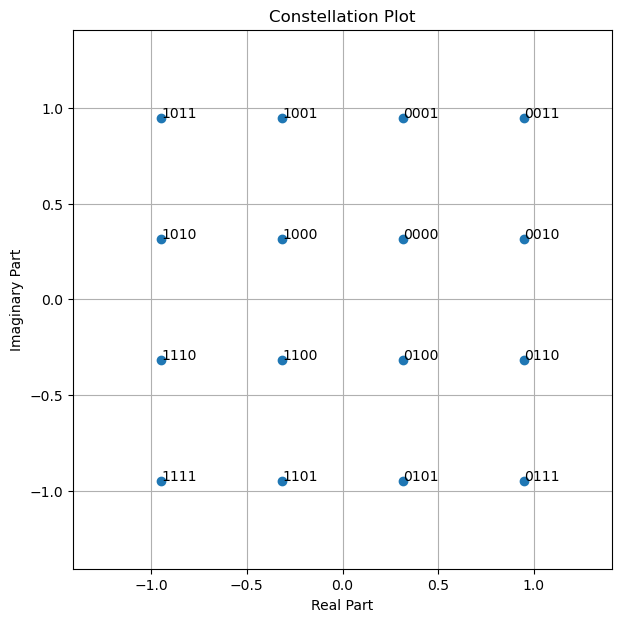

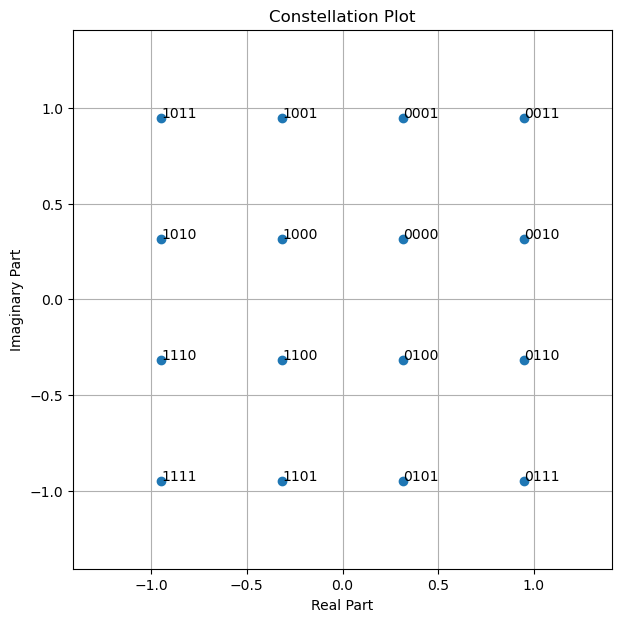

In [153]:
show(points, NUM_BITS_PER_SYMBOL)

In [154]:
def BinarySource(shape):
    return np.random.randint(2, size=shape).astype(np.float32)

In [155]:
def complex_normal(shape, var=1.0):
    stddev = np.sqrt(var/2)
    xr = np.random.normal(loc=0.0, scale=stddev, size=shape)
    xi = np.random.normal(loc=0.0, scale=stddev, size=shape)
    x = xr + 1j*xi
    return x

In [156]:
class Mapper:
    def __init__(self,
                 constellation_type=None,
                 num_bits_per_symbol=None,
                 constellation=None,
                 return_indices=False,
                 #dtype=tf.complex64,
                 #**kwargs
                ):
          self.num_bits_per_symbol = num_bits_per_symbol
          self.binary_base = 2**np.arange(num_bits_per_symbol-1, -1, -1, dtype=int) #array([2, 1], dtype=int32)
          self.points = CreateConstellation(constellation_type, num_bits_per_symbol) #(4,)
    
    def create_symbol(self, inputs):
        #inputs: (64, 1024) #batch_size, bits len
        new_shape = [-1] + [int(inputs.shape[-1] / self.num_bits_per_symbol), self.num_bits_per_symbol] #[-1, 512, 2]
        reinputs_reshaped = np.reshape(inputs, new_shape) #(64, 512, 2)
        # Convert the last dimension to an integer
        int_rep = reinputs_reshaped * self.binary_base #(64, 512, 2)
        int_rep = np.sum(int_rep, axis=-1) #(64, 512)
        int_rep = int_rep.astype(np.int32)
        #print(int_rep.shape)
        # Map integers to constellation symbols
        #x = tf.gather(self.points, int_rep, axis=0)
        symbs_list = [self.points[val_int] for val_int in int_rep]
        symbols=np.array(symbs_list) #(64, 512) complex64
        #print(symbols.dtype)
        return symbols

In [157]:
def ebnodb2no(ebno_db, num_bits_per_symbol, coderate):
    r"""Compute the noise variance `No` for a given `Eb/No` in dB.
    Input
    -----
    ebno_db : float
        The `Eb/No` value in dB.

    num_bits_per_symbol : int
        The number of bits per symbol.

    coderate : float
        The coderate used.

    Output
    ------
    : float
        The value of :math:`N_o` in linear scale.
    """
    #ebno = tf.math.pow(tf.cast(10., dtype), ebno_db/10.)
    ebno = np.power(10, ebno_db/10.0)
    energy_per_symbol = 1
    tmp= (ebno * coderate * float(num_bits_per_symbol)) / float(energy_per_symbol)
    n0 = 1/tmp
    return n0

In [158]:
# custom dataset
class ComplexDataset(Dataset):
    def __init__(self, num_bits_per_symbol, Frame_SIZE=64, Blocklength = 1024, DB_MIN=-10, DB_MAX=20, totaldbs=2000, constellation_type="qam", data_type=np.complex64):
        self.points = CreateConstellation(constellation_type, num_bits_per_symbol)
        print(self.points.shape) #(4,) complex64
        self.shape = ([Frame_SIZE, Blocklength])# Blocklength [64, 1024]
        self.constellation_type = constellation_type
        self.num_bits_per_symbol = num_bits_per_symbol
        self.data_type = data_type
        self.mapper=Mapper(constellation_type=constellation_type, num_bits_per_symbol=num_bits_per_symbol)

        ebno_dbs=np.linspace(DB_MIN, DB_MAX, totaldbs)
        np.random.shuffle(ebno_dbs)
        self.ebno_dbs = ebno_dbs
    
    def __getitem__(self, index):
        ebno_db = self.ebno_dbs[index]

        bits = BinarySource(self.shape)
        #print("Shape of bits: ", bits.shape) #(64, 1024)

        x=self.mapper.create_symbol(bits) #(64, 512) complex64

        n0=ebnodb2no(ebno_db=ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=1.0) #scalar 0.05
        noise=complex_normal(x.shape, 1.0) #(64, 512) complex128
        #print(noise.dtype)
        noise = noise.astype(self.data_type)
        noise *= np.sqrt(n0) 
        y=x+noise #(64, 512)
        signal_complex = torch.from_numpy(y)

        batch={}
        batch['samples']=signal_complex #(64, 512)
        batch['labels']=bits #(64, 1024)
        return batch
    
    def __len__(self):
        return len(self.ebno_dbs)

In [159]:
NUM_BITS_PER_SYMBOL = 4
BATCH_SIZE = 32
Frame_SIZE = 64
Blocklength = 1024
DB_MIN = -20
DB_MAX = 20
dataset = ComplexDataset(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, Frame_SIZE=Frame_SIZE, Blocklength=Blocklength, DB_MIN=DB_MIN, DB_MAX=DB_MAX, totaldbs=BATCH_SIZE*100)

Creating QAM constellation with 4 bits per symbol
(16,)
Creating QAM constellation with 4 bits per symbol


In [160]:
onesample = dataset[0]

In [161]:
onesample.keys()

dict_keys(['samples', 'labels'])

In [162]:
onesample['samples'].shape

torch.Size([64, 256])

In [163]:
onesample['labels'].shape

(64, 1024)

In [164]:
# train, validation and test split
train_size = int(0.8 * len(dataset)) 
val_size = len(dataset) - train_size
train_set, val_set= torch.utils.data.random_split(dataset, [train_size, val_size])

# dataloaders
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(dataset=val_set, batch_size=1, shuffle=True, pin_memory=True)


In [165]:
onebatch = next(iter(val_loader))

In [166]:
onebatch['samples'].shape

torch.Size([1, 64, 256])

In [167]:
onebatch = next(iter(train_loader))

In [168]:
onebatch['samples'].shape

torch.Size([32, 64, 256])

In [169]:
gpuid=0
if torch.cuda.is_available():
    device = torch.device('cuda:'+str(gpuid))  # CUDA GPU 0
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cuda:0


In [170]:
class Simplemodel(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=256):
        super(Simplemodel, self).__init__()
        scale = 8
        self.linear1=nn.Linear(in_features=2, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)
        self.activation = nn.ReLU()
    
    def forward(self, inputs):
        y = inputs #[32,64,256]
        print(y.shape)
   
        # Stack the tensors along a new dimension (axis 0)
        z = torch.stack([y.real, y.imag], dim=0) #[2, 32, 64, 256]
        print(z.shape)
        z = z.permute(1, 2, 3, 0) #[32, 64, 256, 2]
        print("before linear1: ", z.shape)  # Print the shape after the convolutional layer

        z = self.linear1(z) #[32,64,256,32]
        print("After cnn1: ", z.shape)  # Print the shape after the convolutional layer

        z = self.activation(z)#[32,64,256,32]
        print("After activation: ", z.shape)
        z = self.linear2(z) #[32,64,256,4]
        print("After linear2: ", z.shape)
        z = nn.Sigmoid()(z) #[32,64,256,32]
        print("After sigmoid: ", z.shape)
        z = z.flatten(-2, -1) #[32, 64, 1024]
        print("After flatten: ", z.shape)
        return z

In [171]:
model = Simplemodel(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

In [172]:
output = model(onebatch['samples']) #[32, 64, 512] =>[32, 64, 1024]

torch.Size([32, 64, 256])
torch.Size([2, 32, 64, 256])
before linear1:  torch.Size([32, 64, 256, 2])
After cnn1:  torch.Size([32, 64, 256, 32])
After activation:  torch.Size([32, 64, 256, 32])
After linear2:  torch.Size([32, 64, 256, 4])
After sigmoid:  torch.Size([32, 64, 256, 4])
After flatten:  torch.Size([32, 64, 1024])


Model1 + CNN

In [173]:
class Simplemodel1(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=256):
        super(Simplemodel1, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding = (3 - 1) // 2) # Add a CNN layer
        scale = 8
        self.linear1=nn.Linear(in_features=4, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)        
        self.activation = nn.ReLU()

    def forward(self, inputs):
        y = inputs
        
        z = torch.stack([y.real, y.imag], dim=1) #[2, 32, 64, 256]

        z = self.cnn1(z) # [32, 2, 64, 256]
        # print("After cnn1: ", z.shape)  # Print the shape after the convolutional layer
        z = self.activation(z)
        # print("Before reshaping: ", z.shape)# [32, 2, 64, 256]

        z = z.permute(0, 2, 3, 1) #[32, 64, 256, 2]
        # print("Before linear1: ", z.shape)  # Print the shape before the linear layer
        
        z = self.linear1(z)
        # print("After linear1: ", z.shape)  # Print the shape before the linear layer
        
        z = self.activation(z)#[32,64,256,32]
        # print("Before linear1: ", z.shape)  # Print the shape before the linear layer

        z = self.linear2(z)
        # print("After linear2: ", z.shape)  # Print the shape before the linear layer
        z = nn.Sigmoid()(z) #[32,64,256,32]

        # z = z.view(-1,32,4) #[batch_size, num_bits_per_symbol]
        # print("After model: ", z.shape)  # Print the shape before the linear layer

        return z

In [174]:
model1 = Simplemodel1(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

In [175]:
output = model1(onebatch['samples']) 


In [176]:
output.shape

torch.Size([32, 64, 256, 4])

In [177]:
output.dtype

torch.float32

In [178]:
# Setup loss and optimizer pip install ipywidgets
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [179]:
test=torch.tensor([0,0,0,1,1,1], dtype=torch.float)

In [180]:
loss_fn(test,test)

tensor(0.)

In [181]:
onebatch['labels'].shape

torch.Size([32, 64, 1024])

In [182]:
onebatch['labels'].dtype

torch.float32

In [183]:
loss_fn(output,onebatch['labels'])

ValueError: Using a target size (torch.Size([32, 64, 1024])) that is different to the input size (torch.Size([32, 64, 256, 4])) is deprecated. Please ensure they have the same size.

Model2 + batch norm

In [184]:
class Simplemodel2(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=256):
        super(Simplemodel2, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding = (3 - 1) // 2) # Add a CNN layer
        scale = 8
        self.linear1=nn.Linear(in_features=4, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol) 
        self.batch_norm2d = nn.BatchNorm2d(num_features=4)

       
        self.activation = nn.ReLU()

    def forward(self, inputs):
        y = inputs
        
        z = torch.stack([y.real, y.imag], dim=1) #[2, 32, 64, 256]

        z = self.cnn1(z) # [32, 2, 64, 256]
        # print("After cnn1: ", z.shape)  # Print the shape after the convolutional layer
        z= self.batch_norm2d(z)
        
        z = self.activation(z)
        # print("Before reshaping: ", z.shape)# [32, 2, 64, 256]

        z = z.permute(0, 2, 3, 1) #[32, 64, 256, 2]
        # print("Before linear1: ", z.shape)  # Print the shape before the linear layer
        
        z = self.linear1(z)
        # print("After linear1: ", z.shape)  # Print the shape before the linear layer
        
        z = self.activation(z)#[32,64,256,32]
        # print("Before linear1: ", z.shape)  # Print the shape before the linear layer

        z = self.linear2(z)
        # print("After linear2: ", z.shape)  # Print the shape before the linear layer
        z = nn.Sigmoid()(z) #[32,64,256,32]

        # z = z.view(-1,32,4) #[batch_size, num_bits_per_symbol]
        # print("After model: ", z.shape)  # Print the shape before the linear layer

        return z

In [185]:
model2 = Simplemodel2(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

In [186]:
output = model2(onebatch['samples']) 


In [187]:
output.shape


torch.Size([32, 64, 256, 4])

In [188]:
# Setup loss and optimizer pip install ipywidgets
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [189]:
test=torch.tensor([0,0,0,1,1,1], dtype=torch.float)

In [190]:
loss_fn(test,test)

tensor(0.)

In [191]:
onebatch['labels'] = onebatch['labels'].view(32, 64, 256,4)
onebatch['labels'].shape

torch.Size([32, 64, 256, 4])

In [192]:
loss_fn(output,onebatch['labels'])

tensor(0.6961, grad_fn=<BinaryCrossEntropyBackward0>)

Model2 Tuning

In [193]:
class Simplemodel2_2(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=256, out_channels=8, scale=8):
        super(Simplemodel2_2, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=2, out_channels=out_channels, kernel_size=3, stride=1, padding = (3 - 1) // 2) # Add a CNN layer
        self.linear1=nn.Linear(in_features=out_channels, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)        
        self.activation = nn.ReLU()
        self.batch_norm2d = nn.BatchNorm2d(num_features=out_channels)


    def forward(self, inputs):
        y = inputs
        
        z = torch.stack([y.real, y.imag], dim=1) #[2, 32, 64, 256]

        z = self.cnn1(z) # [32, 2, 64, 256]
        z= self.batch_norm2d(z)

        z = self.activation(z)

        z = z.permute(0, 2, 3, 1) #[32, 64, 256, 2]
        
        z = self.linear1(z)
        
        z = self.activation(z)#[32,64,256,32]

        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[32,64,256,32]


        return z

In [194]:
model2_2 = Simplemodel2_2(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
output = model2_2(onebatch['samples']) 
loss_fn(output,onebatch['labels'])

tensor(0.6978, grad_fn=<BinaryCrossEntropyBackward0>)

In [195]:
for out_channels in [4, 8, 16, 32, 64, 128, 256]:
    model = Simplemodel2_2(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength, out_channels=out_channels)
    output = model(onebatch['samples']) 
    loss = loss_fn(output,onebatch['labels'])
    print(f"out_channels: {out_channels}, loss: {loss}")

out_channels: 4, loss: 0.7063580751419067
out_channels: 8, loss: 0.6990205645561218
out_channels: 16, loss: 0.6942257881164551
out_channels: 32, loss: 0.6966648101806641
out_channels: 64, loss: 0.6970628499984741
out_channels: 128, loss: 0.6989198327064514
out_channels: 256, loss: 0.6996558904647827


In [196]:
for scale in [4, 8, 16, 32, 64, 128, 256]:
    model = Simplemodel2_2(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength, out_channels=64, scale=scale)
    output = model(onebatch['samples']) 
    loss = loss_fn(output,onebatch['labels'])
    print(f"scale {scale}, loss: {loss}")

scale 4, loss: 0.6961226463317871
scale 8, loss: 0.6955613493919373
scale 16, loss: 0.6968110203742981
scale 32, loss: 0.6984708309173584
scale 64, loss: 0.6981329917907715
scale 128, loss: 0.6973914504051208
scale 256, loss: 0.6948480010032654


Model 3 + more CNN layers, changed the out_channels and kernnel_size too

In [197]:
class Simplemodel3(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=256):
        super(Simplemodel3, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, stride=1, padding = (3 - 1) // 2) # Add a CNN layer
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding = (5 - 1) // 2) # Add a CNN layer
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=256, kernel_size=9, stride=1, padding = (9 - 1) // 2) # Add a CNN layer

        self.batch_norm2d1 = nn.BatchNorm2d(num_features=8)
        self.batch_norm2d2 = nn.BatchNorm2d(num_features=32)
        self.batch_norm2d3 = nn.BatchNorm2d(num_features=256)

        scale = 8
        self.linear1=nn.Linear(in_features=256, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)        
        self.activation = nn.ReLU()

    def forward(self, inputs):
        y = inputs
        
        z = torch.stack([y.real, y.imag], dim=1) #[2, 32, 64, 256]

        z = self.cnn1(z) # [32, 2, 64, 256]
        z= self.batch_norm2d1(z)

        z = self.activation(z)

        z = self.cnn2(z) # [32, 2, 64, 256]
        z= self.batch_norm2d2(z)

        z = self.activation(z)
        
        z = self.cnn3(z) # [32, 2, 64, 256]
        z= self.batch_norm2d3(z)

        z = self.activation(z)
        
        z = z.permute(0, 2, 3, 1) #[32, 64, 256, 2]
        
        z = self.linear1(z)
        
        z = self.activation(z)#[32,64,256,32]

        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[32,64,256,32]


        return z

In [198]:
model3 = Simplemodel3(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)


In [199]:
output = model3(onebatch['samples']) 


In [200]:
loss_fn(output,onebatch['labels'])

tensor(0.6957, grad_fn=<BinaryCrossEntropyBackward0>)

Model 4 test different activation function

In [233]:
class Simplemodel4(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=256, out_channels=8, scale=8, activation=nn.Sigmoid()):
        super(Simplemodel4, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=2, out_channels=out_channels, kernel_size=3, stride=1, padding = (3 - 1) // 2) # Add a CNN layer
        self.linear1=nn.Linear(in_features=out_channels, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)        
        self.activation = activation

    def forward(self, inputs):
        y = inputs
        
        z = torch.stack([y.real, y.imag], dim=1) #[2, 32, 64, 256]

        z = self.cnn1(z) # [32, 2, 64, 256]
        z = self.activation(z)

        z = z.permute(0, 2, 3, 1) #[32, 64, 256, 2]
        
        z = self.linear1(z)
        
        z = self.activation(z)#[32,64,256,32]

        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[32,64,256,32]


        return z

In [234]:
model4 = Simplemodel4(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
output = model4(onebatch['samples']) 
loss_fn(output,onebatch['labels'])

tensor(0.7068, grad_fn=<BinaryCrossEntropyBackward0>)

In [235]:
class Simplemodel4_1(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=256, out_channels=8, scale=8, activation=nn.Sigmoid()):
        super(Simplemodel4_1, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=2, out_channels=out_channels, kernel_size=3, stride=1, padding = (3 - 1) // 2) # Add a CNN layer
        self.linear1=nn.Linear(in_features=out_channels, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)        
        self.activation = activation
        self.softmax = nn.Softmax(dim=1)  # Specify the dimension, e.g., dim=1 for feature dimension

    def forward(self, inputs):
        y = inputs
        z = torch.stack([y.real, y.imag], dim=1) #[2, 32, 64, 256]
        z = self.cnn1(z) # [32, 2, 64, 256]
        z = self.activation(z)
        z = z.permute(0, 2, 3, 1) #[32, 64, 256, 2]
        z = self.linear1(z)
        z = self.activation(z)#[32,64,256,32]
        z = self.linear2(z)
        z = self.softmax(z) #[32,64,256,32]
        return z

In [236]:
model4_1 = Simplemodel4_1(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
output = model4_1(onebatch['samples']) 
loss_fn(output,onebatch['labels'])

tensor(2.0874, grad_fn=<BinaryCrossEntropyBackward0>)

In [237]:
for activation in [nn.Sigmoid(), nn.ReLU(), nn.LeakyReLU(), nn.Tanh(),nn.Softmax()]:
    model = Simplemodel4(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength, out_channels=64, activation=activation)
    output = model(onebatch['samples']) 
    loss = loss_fn(output,onebatch['labels'])
    print(f"Activation: {activation}, loss: {loss}")

Activation: Sigmoid(), loss: 0.6996446847915649
Activation: ReLU(), loss: 0.6946858167648315
Activation: LeakyReLU(negative_slope=0.01), loss: 0.6936918497085571
Activation: Tanh(), loss: 0.6972672343254089
Activation: Softmax(dim=None), loss: 0.6952475309371948


c:\Users\Kenneth\anaconda3\envs\gpuenv\Lib\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Model5 add dropout

In [238]:
class Simplemodel5(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=256, out_channels=8, scale=8):
        super(Simplemodel5, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=2, out_channels=out_channels, kernel_size=3, stride=1, padding = (3 - 1) // 2) # Add a CNN layer
        self.linear1=nn.Linear(in_features=out_channels, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)        
        self.activation = nn.Sigmoid()
        self.cnn_dropout = nn.Dropout2d(p=0.2)  # Dropout for convolutional layers
        self.linear_dropout = nn.Dropout(p=0.5)  # Dropout for fully connected layers

    def forward(self, inputs):
        y = inputs
        
        z = torch.stack([y.real, y.imag], dim=1) #[2, 32, 64, 256]

        z = self.cnn1(z) # [32, 2, 64, 256]
        z = self.activation(z)
        z = self.cnn_dropout(z) # Dropout for convolutional layers

        z = z.permute(0, 2, 3, 1) #[32, 64, 256, 2]
        
        z = self.linear1(z)
        
        z = self.activation(z)#[32,64,256,32]
        z = self.linear_dropout(z) # Dropout for fully connected layers

        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[32,64,256,32]


        return z

In [239]:
model5 = Simplemodel5(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
output = model5(onebatch['samples']) 
loss_fn(output,onebatch['labels'])

tensor(0.7137, grad_fn=<BinaryCrossEntropyBackward0>)

In [240]:
import os
trainoutput=os.path.join('output','exp0212')
os.makedirs(trainoutput, exist_ok=True)
print("Trainoutput folder:", trainoutput)

Trainoutput folder: output\exp0212


In [241]:
train_losses = []
val_losses = []
val_BERs = []

In [242]:
model=model1.to(device)

In [243]:
from tqdm.auto import tqdm
# Training loop
start_epoch = 0
num_epochs =20
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass 
        labels = labels.view(32, 64, 256,4)
        loss = loss_fn(outputs, labels) 
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]
    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            labels = labels.view(1, 64, 256,4)

            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
            error_rate = error_count / len(labels.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())
            
    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    # Print or log validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")
    


c:\Users\Kenneth\anaconda3\envs\gpuenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 369.69it/s]


Epoch [1/20], Loss: 0.7048, Val Loss: 0.7029, Val BER: 0.5062


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.78it/s]


Epoch [2/20], Loss: 0.7048, Val Loss: 0.7021, Val BER: 0.5061


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 385.03it/s]


Epoch [3/20], Loss: 0.7048, Val Loss: 0.7032, Val BER: 0.5062


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 382.73it/s]


Epoch [4/20], Loss: 0.7048, Val Loss: 0.7238, Val BER: 0.5061


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 387.13it/s]


Epoch [5/20], Loss: 0.7048, Val Loss: 0.7022, Val BER: 0.5060


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 381.48it/s]


Epoch [6/20], Loss: 0.7048, Val Loss: 0.7032, Val BER: 0.5061


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 367.98it/s]


Epoch [7/20], Loss: 0.7048, Val Loss: 0.7046, Val BER: 0.5061


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 374.01it/s]


Epoch [8/20], Loss: 0.7048, Val Loss: 0.7094, Val BER: 0.5060


 42%|████████████████████████▋                                 | 34/80 [00:03<00:04, 11.33it/s]


KeyboardInterrupt: 

In [313]:
class Simplemodel2(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=256):
        super(Simplemodel2, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, stride=1, padding = (3 - 1) // 2) # Add a CNN layer
        scale = 8
        self.linear1=nn.Linear(in_features=4, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)        
        self.activation = nn.ReLU()

    def forward(self, inputs):
        y = inputs
        
        z = torch.stack([y.real, y.imag], dim=1) #[2, 32, 64, 256]

        z = self.cnn1(z) # [32, 2, 64, 256]
        # print("After cnn1: ", z.shape)  # Print the shape after the convolutional layer
        z = self.activation(z)
        # print("Before reshaping: ", z.shape)# [32, 2, 64, 256]

        z = z.permute(0, 2, 3, 1) #[32, 64, 256, 2]
        # print("Before linear1: ", z.shape)  # Print the shape before the linear layer
        
        z = self.linear1(z)
        # print("After linear1: ", z.shape)  # Print the shape before the linear layer
        
        z = self.activation(z)#[32,64,256,32]
        # print("Before linear1: ", z.shape)  # Print the shape before the linear layer

        z = self.linear2(z)
        # print("After linear2: ", z.shape)  # Print the shape before the linear layer
        z = nn.Sigmoid()(z) #[32,64,256,32]

        # z = z.view(-1,32,4) #[batch_size, num_bits_per_symbol]
        # print("After model: ", z.shape)  # Print the shape before the linear layer

        return z

In [314]:
model2 = Simplemodel2(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)

In [316]:
output = model2(onebatch['samples']) 


In [323]:
output.shape


torch.Size([32, 64, 256, 4])

In [326]:
# Setup loss and optimizer pip install ipywidgets
loss_fn = nn.BCELoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [327]:
test=torch.tensor([0,0,0,1,1,1], dtype=torch.float)

In [328]:
loss_fn(test,test)

tensor(0.)

In [333]:
onebatch['labels'] = onebatch['labels'].view(32, 64, 256,4)
onebatch['labels'].shape

torch.Size([32, 64, 256, 4])

In [334]:
loss_fn(output,onebatch['labels'])

tensor(0.6992, grad_fn=<BinaryCrossEntropyBackward0>)

Model2 Tuning

In [362]:
class Simplemodel2_2(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=256, out_channels=8, scale=8):
        super(Simplemodel2_2, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=2, out_channels=out_channels, kernel_size=3, stride=1, padding = (3 - 1) // 2) # Add a CNN layer
        self.linear1=nn.Linear(in_features=out_channels, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)        
        self.activation = nn.ReLU()

    def forward(self, inputs):
        y = inputs
        
        z = torch.stack([y.real, y.imag], dim=1) #[2, 32, 64, 256]

        z = self.cnn1(z) # [32, 2, 64, 256]
        z = self.activation(z)

        z = z.permute(0, 2, 3, 1) #[32, 64, 256, 2]
        
        z = self.linear1(z)
        
        z = self.activation(z)#[32,64,256,32]

        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[32,64,256,32]


        return z

In [363]:
model2_2 = Simplemodel2_2(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
output = model2_2(onebatch['samples']) 
loss_fn(output,onebatch['labels'])

tensor(0.6992, grad_fn=<BinaryCrossEntropyBackward0>)

In [359]:
for out_channels in [4, 8, 16, 32, 64, 128, 256]:
    model = Simplemodel2_2(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength, out_channels=out_channels)
    output = model(onebatch['samples']) 
    loss = loss_fn(output,onebatch['labels'])
    print(f"out_channels: {out_channels}, loss: {loss}")

out_channels: 4, loss: 0.6964638829231262
out_channels: 8, loss: 0.6983799934387207
out_channels: 16, loss: 0.7030550837516785
out_channels: 32, loss: 0.696799635887146
out_channels: 64, loss: 0.6935634016990662
out_channels: 128, loss: 0.6966190934181213
out_channels: 256, loss: 0.6962556838989258


In [364]:
for scale in [4, 8, 16, 32, 64, 128, 256]:
    model = Simplemodel2_2(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength, out_channels=64, scale=scale)
    output = model(onebatch['samples']) 
    loss = loss_fn(output,onebatch['labels'])
    print(f"scale {scale}, loss: {loss}")

scale 4, loss: 0.6937697529792786
scale 8, loss: 0.6943815350532532
scale 16, loss: 0.6958500742912292
scale 32, loss: 0.69366455078125
scale 64, loss: 0.6967389583587646
scale 128, loss: 0.694881021976471
scale 256, loss: 0.6944703459739685


Model 3

In [371]:
class Simplemodel3(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=256):
        super(Simplemodel3, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=2, out_channels=8, kernel_size=3, stride=1, padding = (3 - 1) // 2) # Add a CNN layer
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3, stride=1, padding = (3 - 1) // 2) # Add a CNN layer

        scale = 8
        self.linear1=nn.Linear(in_features=32, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)        
        self.activation = nn.ReLU()

    def forward(self, inputs):
        y = inputs
        
        z = torch.stack([y.real, y.imag], dim=1) #[2, 32, 64, 256]

        z = self.cnn1(z) # [32, 2, 64, 256]
        z = self.activation(z)

        z = self.cnn2(z) # [32, 2, 64, 256]
        z = self.activation(z)
        
        z = z.permute(0, 2, 3, 1) #[32, 64, 256, 2]
        
        z = self.linear1(z)
        
        z = self.activation(z)#[32,64,256,32]

        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[32,64,256,32]


        return z

In [372]:
model3 = Simplemodel3(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)


In [373]:
output = model3(onebatch['samples']) 


In [374]:
loss_fn(output,onebatch['labels'])

tensor(0.6957, grad_fn=<BinaryCrossEntropyBackward0>)

Model 4

In [376]:
class Simplemodel4(nn.Module):

    def __init__(self, num_bits_per_symbol, H=64, W=256, out_channels=8, scale=8):
        super(Simplemodel4, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=2, out_channels=out_channels, kernel_size=3, stride=1, padding = (3 - 1) // 2) # Add a CNN layer
        self.linear1=nn.Linear(in_features=out_channels, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)        
        self.activation = nn.Sigmoid()

    def forward(self, inputs):
        y = inputs
        
        z = torch.stack([y.real, y.imag], dim=1) #[2, 32, 64, 256]

        z = self.cnn1(z) # [32, 2, 64, 256]
        z = self.activation(z)

        z = z.permute(0, 2, 3, 1) #[32, 64, 256, 2]
        
        z = self.linear1(z)
        
        z = self.activation(z)#[32,64,256,32]

        z = self.linear2(z)
        z = nn.Sigmoid()(z) #[32,64,256,32]


        return z

In [377]:
model4 = Simplemodel4(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
output = model4(onebatch['samples']) 
loss_fn(output,onebatch['labels'])

tensor(0.7069, grad_fn=<BinaryCrossEntropyBackward0>)

In [ ]:
class Simplemodel4(nn.Module):
    def __init__(self, num_bits_per_symbol, H=64, W=256, out_channels=8, scale=8, activation=nn.Sigmoid()):
        super(Simplemodel4, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=2, out_channels=out_channels, kernel_size=3, stride=1, padding = (3 - 1) // 2) # Add a CNN layer
        self.linear1=nn.Linear(in_features=out_channels, out_features=scale*num_bits_per_symbol)
        self.linear2=nn.Linear(in_features=scale*num_bits_per_symbol, out_features=num_bits_per_symbol)        
        self.activation = activation

    def forward(self, inputs):
        y = inputs
        z = torch.stack([y.real, y.imag], dim=1) #[2, 32, 64, 256]
        z = self.cnn1(z) # [32, 2, 64, 256]
        z = self.activation(z)
        z = z.permute(0, 2, 3, 1) #[32, 64, 256, 2]
        z = self.linear1(z)
        z = self.activation(z)#[32,64,256,32]
        z = self.linear2(z)
        z = torch.sigmoid(z)#[32,64,256,32]
        return z

In [385]:
model4 = Simplemodel4(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength)
output = model4(onebatch['samples']) 
loss_fn(output,onebatch['labels'])

TypeError: Sigmoid.__init__() takes 1 positional argument but 2 were given

In [ ]:
for activation in [nn.Sigmoid(), nn.ReLU(), nn.LeakyReLU()]:
    model = Simplemodel4(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, H=Frame_SIZE, W=Blocklength, out_channels=64, activation=activation)
    output = model(onebatch['samples']) 
    loss = loss_fn(output,onebatch['labels'])
    print(f"Activation: {activation}, loss: {loss}")

In [264]:
import os
trainoutput=os.path.join('output','exp0212')
os.makedirs(trainoutput, exist_ok=True)
print("Trainoutput folder:", trainoutput)

Trainoutput folder: output\exp0212


In [265]:
train_losses = []
val_losses = []
val_BERs = []

In [266]:
model=model1.to(device)

In [279]:
from tqdm.auto import tqdm
# Training loop
start_epoch = 0
num_epochs =20
for epoch in range(start_epoch, num_epochs):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for index, data_batch in enumerate(tqdm(train_loader)):
        batch = {k: v.to(device) for k, v in data_batch.items()}
        samples = batch['samples']
        labels = batch['labels']
        outputs = model(samples)  # forward pass 
        labels = labels.view(32, 64, 256,4)
        loss = loss_fn(outputs, labels) 
        loss.backward()  # backward pass
        optimizer.step()  # update the weights
        total_loss += loss.item()  # accumulate the loss
        optimizer.zero_grad()  # Zero the gradients

    # Print average loss for the epoch
    average_loss = total_loss / len(train_loader)

    # Validation
    model.eval()  # Set the model to evaluation mode
    BER_batch=[]
    with torch.no_grad():
        for index, data_batch in enumerate(tqdm(val_loader)):
            batch = {k: v.to(device) for k, v in data_batch.items()}
            samples = batch['samples']
            labels = batch['labels']
            labels = labels.view(1, 64, 256,4)

            val_outputs = model(samples)
            val_loss = loss_fn(val_outputs, labels)

            # Convert probabilities to binary predictions (0 or 1)
            binary_predictions = torch.round(val_outputs)

            # Calculate Bit Error Rate (BER)
            error_count = torch.sum(binary_predictions != labels).float()  # Count of unequal bits
            error_rate = error_count / len(labels.flatten())  # Error rate calculation
            BER_batch.append(error_rate.item())
            
    # Save performance details
    train_losses.append(average_loss)
    val_losses.append(val_loss.item())
    BER_batch_mean=np.mean(BER_batch)
    val_BERs.append(BER_batch_mean)#(BER.item())

    # Print or log validation loss after each epoch
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Val Loss: {val_loss:.4f}, Val BER: {BER_batch_mean:.4f}")
    


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 384.86it/s]


Epoch [1/20], Loss: 0.7024, Val Loss: 0.7019, Val BER: 0.4984


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 383.24it/s]


Epoch [2/20], Loss: 0.7024, Val Loss: 0.7040, Val BER: 0.4980


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 387.18it/s]


Epoch [3/20], Loss: 0.7024, Val Loss: 0.7018, Val BER: 0.4982


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 388.70it/s]


Epoch [4/20], Loss: 0.7024, Val Loss: 0.7017, Val BER: 0.4983


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 385.90it/s]


Epoch [5/20], Loss: 0.7024, Val Loss: 0.7023, Val BER: 0.4983


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.13it/s]


Epoch [6/20], Loss: 0.7024, Val Loss: 0.7019, Val BER: 0.4983


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 389.67it/s]


Epoch [7/20], Loss: 0.7024, Val Loss: 0.7017, Val BER: 0.4982


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 386.02it/s]


Epoch [8/20], Loss: 0.7024, Val Loss: 0.7016, Val BER: 0.4981


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 384.27it/s]


Epoch [9/20], Loss: 0.7024, Val Loss: 0.7023, Val BER: 0.4982


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 390.02it/s]


Epoch [10/20], Loss: 0.7024, Val Loss: 0.7020, Val BER: 0.4982


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 387.43it/s]


Epoch [11/20], Loss: 0.7024, Val Loss: 0.7012, Val BER: 0.4982


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 388.85it/s]


Epoch [12/20], Loss: 0.7024, Val Loss: 0.7019, Val BER: 0.4982


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 389.68it/s]


Epoch [13/20], Loss: 0.7024, Val Loss: 0.7027, Val BER: 0.4983


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 383.01it/s]


Epoch [14/20], Loss: 0.7024, Val Loss: 0.7031, Val BER: 0.4982


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 375.32it/s]


Epoch [15/20], Loss: 0.7024, Val Loss: 0.7015, Val BER: 0.4983


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 387.65it/s]


Epoch [16/20], Loss: 0.7024, Val Loss: 0.7022, Val BER: 0.4981


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 388.72it/s]


Epoch [17/20], Loss: 0.7024, Val Loss: 0.7020, Val BER: 0.4983


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 385.33it/s]


Epoch [18/20], Loss: 0.7024, Val Loss: 0.7021, Val BER: 0.4982


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 372.38it/s]


Epoch [19/20], Loss: 0.7024, Val Loss: 0.7033, Val BER: 0.4983


100%|███████████████████████████████████████████████████████| 640/640 [00:01<00:00, 366.11it/s]

Epoch [20/20], Loss: 0.7024, Val Loss: 0.7027, Val BER: 0.4983


In [268]:
# Save the final trained model
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
}
modelsave_path = os.path.join(trainoutput, 'simple_model.pth')
torch.save(checkpoint, modelsave_path)

In [ ]:
# Plot Training Loss and Validation Loss
plt.figure(figsize=(7, 3))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.grid(True)

In [ ]:
# Plot Validation BER
plt.figure(figsize=(7, 3))
plt.plot(val_BERs, label='Validation BER')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()
plt.title('Bit Error Rate (BER) on validation set')
plt.grid(True)